#Get Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
if not os.path.exists("data"):
  os.mkdir("data")

In [3]:
shutil.copy("/content/drive/MyDrive/SLAM/rgbd_dataset_freiburg2_pioneer_slam.tgz", "/content/data/rgbd_dataset_freiburg2_pioneer_slam.tgz")

'/content/data/rgbd_dataset_freiburg2_pioneer_slam.tgz'

In [4]:
cd data/

/content/data


In [5]:
!tar -xvf /content/data/rgbd_dataset_freiburg2_pioneer_slam.tgz

Streaming output truncated to the last 5000 lines.
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878272.919011.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878215.241746.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878214.309826.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878282.787543.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878215.473758.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878199.838004.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878330.203693.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878278.215516.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878201.442332.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878207.641861.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878290.329363.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878200.544672.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878293.562699.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878298.372257.png
rgbd_dataset_freiburg2_pioneer_slam/rgb/1311878279.485606.png
rgbd_dataset_freibu

#Imports

In [6]:
# importing required libraries
import pickle
import numpy as np
from numpy.linalg import inv
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
import torchvision.transforms as transforms

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import os
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import Dataset

from utils import *
from data_factory import *
from networks import *

#Read Data

In [7]:
rgb_images = os.listdir("/content/data/rgbd_dataset_freiburg2_pioneer_slam/rgb")
rgb_images.sort()
depth_images = os.listdir("/content/data/rgbd_dataset_freiburg2_pioneer_slam/depth")
depth_images.sort()

In [8]:
len(rgb_images), len(depth_images)

(2921, 2890)

In [9]:
rgb_images[0]

'1311878194.274451.png'

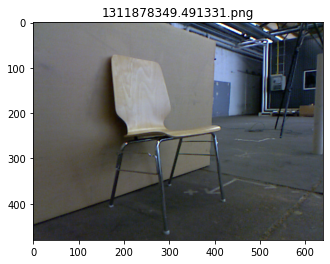

<Figure size 432x288 with 0 Axes>

In [10]:
root_dir = "/content/data/rgbd_dataset_freiburg2_pioneer_slam/"
show_image(root_dir+"/rgb/", rgb_images[-1])

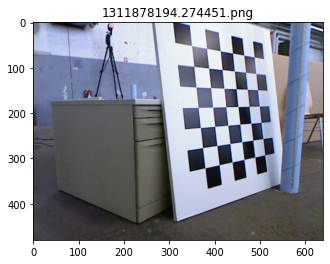

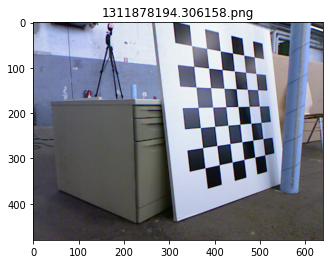

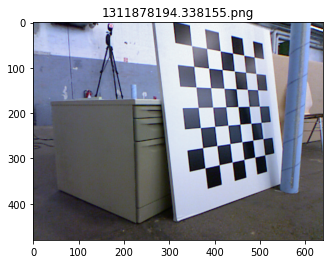

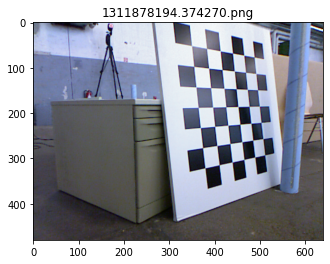

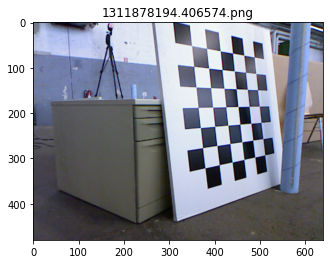

<Figure size 432x288 with 0 Axes>

In [11]:
for i in range(5):
  show_image(root_dir+"/rgb/", rgb_images[i])

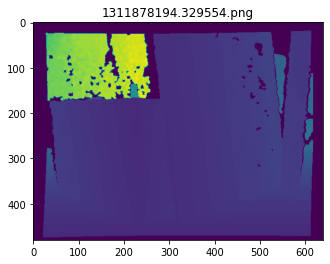

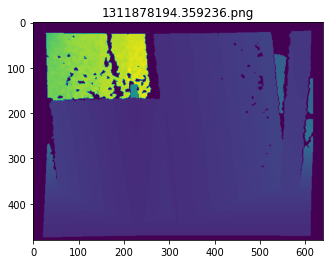

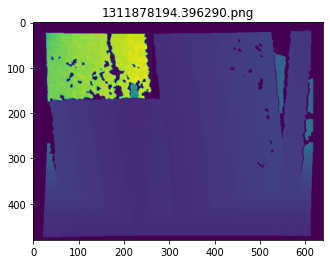

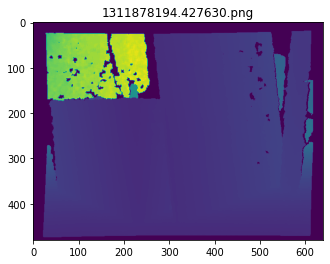

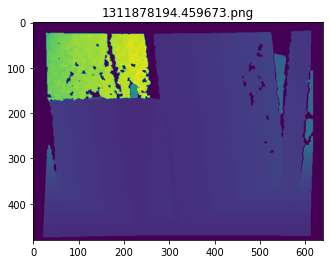

<Figure size 432x288 with 0 Axes>

In [12]:
for i in range(5):
  show_image(root_dir+"/depth/", depth_images[i])

#Plot Ground Truth

Quaternion

In [ ]:
gt = np.loadtxt("/content/data/rgbd_dataset_freiburg2_pioneer_slam/groundtruth.txt")

In [ ]:
gt.shape

(44212, 8)

In [ ]:
44212/15.3

2889.673202614379

In [ ]:
timestamps = gt[:, 0]
t = gt[:, 1:4]
q = gt[:, 4:]

In [ ]:
timestamps[0]

1311878193.7868

In [ ]:
t[0]

array([-2.3174, -2.1669,  0.5873])

In [ ]:
odometry = t[1:, :] - t[:-1, :]
odometry.shape

(44211, 3)

In [ ]:
np.around(odometry[:10], 4)

array([[ 0.    ,  0.    ,  0.0001],
       [ 0.    ,  0.    , -0.0001],
       [ 0.    ,  0.    ,  0.0001],
       [ 0.    ,  0.    ,  0.    ],
       [ 0.0001,  0.    ,  0.    ],
       [-0.0001,  0.    ,  0.    ],
       [ 0.    , -0.0001,  0.    ],
       [ 0.0001,  0.0001,  0.    ],
       [ 0.    ,  0.    ,  0.    ],
       [-0.0001,  0.    ,  0.    ]])

In [ ]:
q[0]

array([-0.7163,  0.2094, -0.1836,  0.6398])

In [ ]:
SO3(q[0], t[0])

array([[ 0.84485946, -0.06505188,  0.5309736 , -2.3174    ],
       [-0.534921  , -0.0936152 ,  0.8396858 , -2.1669    ],
       [-0.00492288, -0.99346916, -0.113894  ,  0.5873    ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [ ]:
new_t = []
for j in range(0, t.shape[0], 16):
  new_t.append(t[j])
new_t = np.array(new_t)
t = new_t

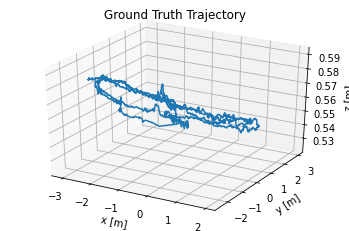

<Figure size 432x288 with 0 Axes>

In [ ]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(t[:,0], t[:,1], t[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth Trajectory')
ax.set_xlim(min(t[:, 0]), max(t[:, 0]))
ax.set_ylim(min(t[:, 1]), max(t[:, 1]))
ax.set_zlim(min(t[:, 2]), max(t[:, 2]))
plt.show()
plt.clf()

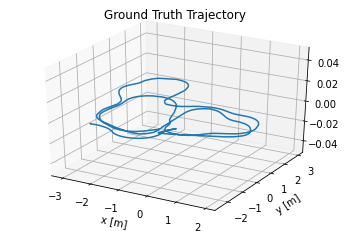

<Figure size 432x288 with 0 Axes>

In [ ]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(t[:,0], t[:,1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
# ax.set_zlabel('z [m]')
ax.set_title('Ground Truth Trajectory')
ax.set_xlim(min(t[:, 0]), max(t[:, 0]))
ax.set_ylim(min(t[:, 1]), max(t[:, 1]))
# ax.set_zlim(min(t[:, 2]), 0.58)
plt.show()
plt.clf()

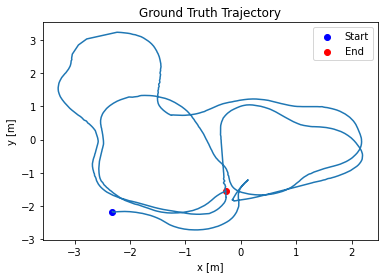

<Figure size 432x288 with 0 Axes>

In [ ]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111)
ax.plot(t[:,0], t[:,1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
# ax.set_zlabel('z [m]')
ax.set_title('Ground Truth Trajectory')
# ax.set_xlim(min(t[:, 0]), max(t[:, 0]))
# ax.set_ylim(min(t[:, 1]), max(t[:, 1]))
# ax.set_zlim(min(t[:, 2]), 0.58)
plt.scatter(t[0, 0], t[0, 1], marker='o', color='b', label='Start')
plt.scatter(t[-1, 0], t[-1, 1], marker='o', color='r', label='End')
plt.legend()
plt.show()
plt.clf()

In [ ]:
new_t.shape

(2764, 3)

#Build ML Pipeline

In [13]:
root_dir = "/content/data/rgbd_dataset_freiburg2_pioneer_slam"

In [14]:
train_data = SLAM_DATA(root_dir, scale_down=4)

Length of dataset:  2890


In [15]:
out = train_data.__getitem__(0)

In [16]:
out[0][0].shape, out[0][1].shape, out[1], out[-1]

(torch.Size([3, 120, 160]),
 torch.Size([1, 120, 160]),
 tensor([ 0.3233,  9.4714, -1.5446]),
 tensor([[ 0.8449, -0.0651,  0.5310, -2.3174],
         [-0.5349, -0.0936,  0.8397, -2.1669],
         [-0.0049, -0.9935, -0.1139,  0.5873],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]))

In [17]:
rgb_text = np.loadtxt("/content/data/rgbd_dataset_freiburg2_pioneer_slam/rgb.txt", dtype=str)
depth_text = np.loadtxt("/content/data/rgbd_dataset_freiburg2_pioneer_slam/depth.txt", dtype=str)
acc_text = np.loadtxt("/content/data/rgbd_dataset_freiburg2_pioneer_slam/accelerometer.txt", dtype=str)
gt_text = np.loadtxt("/content/data/rgbd_dataset_freiburg2_pioneer_slam/groundtruth.txt", dtype=str)

In [18]:
rgb_text.shape, depth_text.shape, acc_text.shape, gt_text.shape

((2921, 2), (2890, 2), (76687, 4), (44212, 8))

In [19]:
print(rgb_text[0])
print(depth_text[0])
print(acc_text[0])
print(gt_text[0])

['1311878194.274451' 'rgb/1311878194.274451.png']
['1311878194.329554' 'depth/1311878194.329554.png']
['1311878193.602737' '0.323296' '9.471380' '-1.544637']
['1311878193.7868' '-2.3174' '-2.1669' '0.5873' '-0.7163' '0.2094'
 '-0.1836' '0.6398']


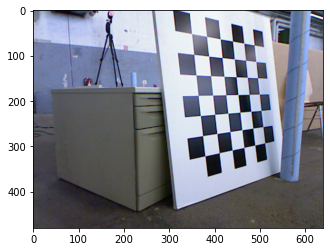

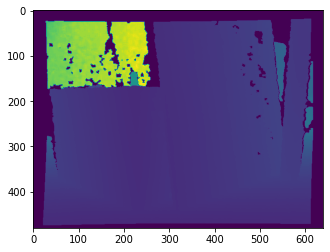

<Figure size 432x288 with 0 Axes>

In [20]:
show_image('/content/data/rgbd_dataset_freiburg2_pioneer_slam/'+rgb_text[0][-1], "")
show_image('/content/data/rgbd_dataset_freiburg2_pioneer_slam/'+depth_text[0][-1], "")

Dataloader

In [21]:
train_dataloader = DataLoader(train_data, batch_size=12, shuffle=True)

Model

In [22]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [23]:
model = VPT().to(device)
print(model)

VPT(
  (rgb_stream): Sequential(
    (0): Conv2d(3, 12, kernel_size=(15, 15), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (depth_stream): Sequential(
    (0): Conv2d(1, 12, kernel_size=(15, 15), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (rnn): GRU(27, 12)
)


#Test Training

In [26]:
train_data = SLAM_DATA(root_dir, scale_down=4)

Length of dataset:  2890


In [27]:
train_dataloader = DataLoader(train_data, batch_size=12, shuffle=True)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [28]:
model = VPT_1().to(device)
print(model)

VPT_1(
  (rgb_stream): Sequential(
    (0): Conv2d(3, 12, kernel_size=(15, 15), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (depth_stream): Sequential(
    (0): Conv2d(1, 12, kernel_size=(15, 15), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (rnn): GRU(27, 12)
)


In [29]:
loss_R = nn.CrossEntropyLoss()
loss_t = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [31]:
size = len(train_data)
all_losses = []
losses =[]
best_loss = 100
model.train()
for i in range(13, size):
  start, stop = i-13, i-1
  rgbs = torch.zeros((12, 3, 120, 160))
  depths = torch.zeros((12, 1, 120, 160))
  odos = torch.zeros((12, 3))
  Ts = torch.zeros((12, 4, 4))
  for j in range(start, stop):
    ((rgb, depth), odo, T) = train_data.__getitem__(j)

    rgbs[j-start, :, :, :] = rgb
    depths[j-start, :, : ,:] = depth
    odos[j-start, :] = odo
    Ts[j-start, :, :] = T
  
  dR, dt = model(rgbs, odos, depths)
  print(dR)
  print(dt)
  break

  _, _, T_now = train_data.__getitem__(i)
  R = T[:3, :3]
  t = T[:3, -1]

  # use latest T variable for immediately previous pose
  R_pre = T[:3, :3].float()
  t_pre = T[:3, -1].float()

  # get prediction
  R_new = dR @ R_pre
  t_new = dt + t_pre

  # loss
  loss = 0.75*loss_R(torch.flatten(R_new), torch.flatten(R)) + 0.25*loss_t(torch.flatten(t_new), torch.flatten(t))
  # print("loss: ", loss.item())
  all_losses.append(loss)
    

  # Backpropagation
  optimizer.zero_grad()
  loss.backward(retain_graph=True)
  optimizer.step()

  if loss.item() < best_loss:
    best_loss = loss.item()
    torch.save(model, "best_model.pt")
    # print("===Model saved===")

  if i % 100 == 0:
    loss, current = loss.item(), i
    losses.append(loss)
    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  # break

torch.Size([12, 27])
tensor([[0.1358, 0.1358, 0.1358],
        [0.1358, 0.1358, 0.1358],
        [0.1358, 0.1358, 0.1358]], grad_fn=<SliceBackward0>)
tensor([0.1358, 0.1358, 0.1358], grad_fn=<SelectBackward0>)


In [32]:
losses

[]

In [33]:
size = len(train_data)
for i in range(13, size):
  start, stop = i-13, i-1
  rgbs = torch.zeros((12, 3, 120, 160))
  depths = torch.zeros((12, 1, 120, 160))
  odos = torch.zeros((12, 3))
  Ts = torch.zeros((12, 4, 4))
  for j in range(start, stop):
    ((rgb, depth), odo, T) = train_data.__getitem__(j)
    # print(rgb.shape)
    # print(depth.shape)
    # print(odo)
    # print(T)
    # print(j)
    rgbs[j, :, :, :] = rgb
    depths[j, :, : ,:] = depth
    odos[j, :] = odo
    Ts[j, :, :] = T
  print(rgbs.shape)
  print(depths.shape)
  print(odos)
  print(Ts.shape)
  break

torch.Size([12, 3, 120, 160])
torch.Size([12, 1, 120, 160])
tensor([[ 0.3233,  9.4714, -1.5446],
        [ 0.2275,  9.2798, -1.3531],
        [ 0.4071,  9.4714, -1.3531],
        [ 0.3233,  9.2798, -1.5446],
        [ 0.4550,  9.4235, -1.4967],
        [ 0.2275,  9.2798, -1.4488],
        [ 0.3233,  9.2798, -1.7362],
        [ 0.2275,  9.2798, -1.3531],
        [ 0.2275,  9.1361, -1.5446],
        [ 0.4071,  9.3756, -1.2573],
        [ 0.4071,  9.4714, -1.5925],
        [ 0.4071,  9.4594, -1.3531]])
torch.Size([12, 4, 4])


In [ ]:
rnn = nn.GRU(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

In [ ]:
rnn = nn.GRU(27, 12, 1)
input = torch.randn(12, 27)
h0 = torch.randn(1, 12)
output, hn = rnn(input, h0)

In [ ]:
output.shape

torch.Size([12, 12])

In [ ]:
hn.shape

torch.Size([1, 12])

In [ ]:
lines = np.load('/content/all_losses.npy', allow_pickle=True)

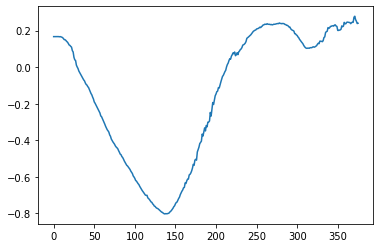

In [ ]:
plt.plot(lines)

#RNN Training

In [34]:
root_dir = "/content/data/rgbd_dataset_freiburg2_pioneer_slam"
train_data = SLAM_DATA(root_dir, scale_down=4)

Length of dataset:  2890


In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VPT_RNN_4().to(device)

In [36]:
loss_R = nn.MSELoss()
loss_t = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [37]:
def get_samples(i, data):
  start, stop = i-13, i-1
  rgbs = torch.zeros((12, 3, 120, 160))
  depths = torch.zeros((12, 1, 120, 160))
  odos = torch.zeros((12, 3))
  Ts = torch.zeros((12, 4, 4))
  for j in range(start, stop):
    ((rgb, depth), odo, T) = data.__getitem__(j)

    rgbs[j-start, :, :, :] = torch.from_numpy(rgb)
    depths[j-start, :, : ,:] = torch.from_numpy(depth)
    odos[j-start, :] = torch.from_numpy(odo)
    Ts[j-start, :, :] = torch.from_numpy(T)

  return rgbs, depths, odos, Ts

In [ ]:
size = len(train_data)
all_losses = []
losses =[]
best_loss = 100
model.train()
for i in range(size):
    rgbs, depths, odos, Ts = get_samples(i, train_data)
    rgbs = rgbs.to(device)
    depths = depths.to(device)
    odos = odos.to(device)
    Ts = Ts.to(device)
    
    dR, dt = model(rgbs, odos, depths)
    # print(dR)
    # print(dt)
    # break

    _, _, T_now = train_data.__getitem__(i)
    R = T_now[:3, :3].to(device)
    t = T_now[:3, -1].to(device)

    # use latest T variable for immediately previous pose
    # R_pre = T[:3, :3].float()
    # t_pre = T[:3, -1].float()

    # get prediction
    R_new = dR @ Ts[-1, :3, :3].float()
    t_new = dt + Ts[-1, :3, -1].float()

    # loss
    loss = 0.75*loss_R(torch.flatten(R_new), torch.flatten(R)) + 0.25*loss_t(torch.flatten(t_new), torch.flatten(t))

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    # print("loss: ", loss.item())
    all_losses.append(loss.detach().cpu())
    np.save("all_losses_vptrnn4_.npy", all_losses)
        
    if loss.item() < best_loss:
      best_loss = loss
      torch.save(model, "vpt_rnn_4_best_model.pt")
      # print("===Model saved===")

    if i % 100 == 0:
      loss, current = loss.item(), i
      # losses.append(loss.detach().cpu())
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

      # break

loss: 0.628830  [    0/ 2890]
loss: 0.155423  [  100/ 2890]
loss: 0.124286  [  200/ 2890]
loss: 0.044093  [  300/ 2890]
loss: 0.011087  [  400/ 2890]
loss: 0.004123  [  500/ 2890]
loss: 0.001373  [  600/ 2890]
loss: 0.000821  [  700/ 2890]
loss: 0.000554  [  800/ 2890]
loss: 0.000533  [  900/ 2890]
loss: 0.000392  [ 1000/ 2890]
loss: 0.000294  [ 1100/ 2890]
loss: 0.000334  [ 1200/ 2890]
loss: 0.000168  [ 1300/ 2890]
loss: 0.000241  [ 1400/ 2890]
loss: 0.000352  [ 1500/ 2890]
loss: 0.001195  [ 1600/ 2890]
loss: 0.000354  [ 1700/ 2890]
loss: 0.000233  [ 1800/ 2890]
loss: 0.000103  [ 1900/ 2890]
loss: 0.000381  [ 2000/ 2890]
loss: 0.000184  [ 2100/ 2890]
loss: 0.000324  [ 2200/ 2890]
loss: 0.000139  [ 2300/ 2890]
loss: 0.000075  [ 2400/ 2890]
loss: 0.000151  [ 2500/ 2890]
loss: 0.000156  [ 2600/ 2890]
loss: 0.000087  [ 2700/ 2890]
loss: 0.000068  [ 2800/ 2890]


In [ ]:
size = len(train_data)
all_losses = []
losses =[]
best_loss = 100
model.train()
for i in range(size):
    rgbs, depths, odos, Ts = get_samples(i, train_data)
    rgbs = rgbs.to(device)
    depths = depths.to(device)
    odos = odos.to(device)
    Ts = Ts.to(device)
    
    _, dt = model(rgbs, odos, depths)
    # print(dR)
    # print(dt)
    # break

    _, _, T_now = train_data.__getitem__(i)
    # R = T_now[:3, :3].to(device)
    t = T_now[:3, -1].to(device)

    # use latest T variable for immediately previous pose
    # R_pre = T[:3, :3].float()
    # t_pre = T[:3, -1].float()

    # get prediction
    # R_new = dR @ Ts[-1, :3, :3].float()
    t_new = dt + Ts[-1, :3, -1].float()

    # loss
    loss = 0.25*loss_t(torch.flatten(t_new), torch.flatten(t)) # + 0.75*loss_R(torch.flatten(R_new), torch.flatten(R)) + 

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    # print("loss: ", loss.item())
    all_losses.append(loss.detach().cpu())
    np.save("all_losses_vptrnn3.npy", all_losses)
        
    if loss.item() < best_loss:
      best_loss = loss
      torch.save(model, "vpt_rnn_3_best_model.pt")
      # print("===Model saved===")

    if i % 100 == 0:
      loss, current = loss.item(), i
      # losses.append(loss.detach().cpu())
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

      # break

loss: 0.534262  [    0/ 2890]
loss: 0.012114  [  100/ 2890]
loss: 0.005618  [  200/ 2890]
loss: 0.001621  [  300/ 2890]
loss: 0.002103  [  400/ 2890]
loss: 0.000596  [  500/ 2890]
loss: 0.000533  [  600/ 2890]
loss: 0.000054  [  700/ 2890]
loss: 0.000474  [  800/ 2890]
loss: 0.000008  [  900/ 2890]
loss: 0.000050  [ 1000/ 2890]
loss: 0.001200  [ 1100/ 2890]
loss: 0.000005  [ 1200/ 2890]
loss: 0.001525  [ 1300/ 2890]
loss: 0.000138  [ 1400/ 2890]
loss: 0.001709  [ 1500/ 2890]
loss: 0.000284  [ 1600/ 2890]
loss: 0.000095  [ 1700/ 2890]
loss: 0.002325  [ 1800/ 2890]
loss: 0.000071  [ 1900/ 2890]
loss: 0.000063  [ 2000/ 2890]
loss: 0.000088  [ 2100/ 2890]
loss: 0.000063  [ 2200/ 2890]
loss: 0.000009  [ 2300/ 2890]
loss: 0.000063  [ 2400/ 2890]
loss: 0.000083  [ 2500/ 2890]
loss: 0.000086  [ 2600/ 2890]
loss: 0.000084  [ 2700/ 2890]
loss: 0.000075  [ 2800/ 2890]


#Train_Val Training

In [ ]:
train_data = SLAM_DATA("/content/data/rgbd_dataset_freiburg2_pioneer_slam", scale_down=4)
val_data = SLAM_DATA("/content/data/rgbd_dataset_freiburg2_pioneer_slam2", scale_down=4)

Length of dataset:  2890
Length of dataset:  2075


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VPT_RNN_4().to(device)
loss_R = nn.MSELoss()
loss_t = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
def get_samples(i, data):
  start, stop = i-13, i-1
  rgbs = torch.zeros((12, 3, 120, 160))
  depths = torch.zeros((12, 1, 120, 160))
  odos = torch.zeros((12, 3))
  Ts = torch.zeros((12, 4, 4))
  for j in range(start, stop):
    ((rgb, depth), odo, T) = data.__getitem__(j)

    rgbs[j-start, :, :, :] = rgb
    depths[j-start, :, : ,:] = depth
    odos[j-start, :] = odo
    Ts[j-start, :, :] = T

  return rgbs, depths, odos, Ts

In [ ]:
size = len(val_data)
train_losses = val_losses = []
# losses =[]
best_loss = 100
model.train()
for i in range(size):
    rgbs_train, depths_train, odos_train, Ts_train = get_samples(i, train_data)
    rgbs_train = rgbs_train.to(device)
    depths_train = depths_train.to(device)
    odos_train = odos_train.to(device)
    Ts_train = Ts_train.to(device)
    
    dR, dt = model(rgbs_train, odos_train, depths_train)
    # print(dR)
    # print(dt)
    # break

    _, _, T_now = train_data.__getitem__(i)
    R = T_now[:3, :3].to(device)
    t = T_now[:3, -1].to(device)

    # use latest T variable for immediately previous pose
    # R_pre = T[:3, :3].float()
    # t_pre = T[:3, -1].float()

    # get prediction
    R_new = dR @ Ts_train[-1, :3, :3].float()
    t_new = dt + Ts_train[-1, :3, -1].float()

    # loss
    train_loss = 0.75*loss_R(torch.flatten(R_new), torch.flatten(R)) + 0.25*loss_t(torch.flatten(t_new), torch.flatten(t))

    optimizer.zero_grad()
    train_loss.backward(retain_graph=True)
    optimizer.step()

    # print("loss: ", loss.item())
    train_losses.append(train_loss.detach().cpu())
    np.save("train_losses_vptrnn4_.npy", train_losses)

    #=======================VAL=======================#
    rgbs_val, depths_val, odos_val, Ts_val = get_samples(i, val_data)
    rgbs_val = rgbs_val.to(device)
    depths_val = depths_val.to(device)
    odos_val = odos_val.to(device)
    Ts_val = Ts_val.to(device)
    
    dR, dt = model(rgbs_val, odos_val, depths_val)
    # print(dR)
    # print(dt)
    # break

    _, _, T_now = val_data.__getitem__(i)
    R = T_now[:3, :3].to(device)
    t = T_now[:3, -1].to(device)

    # use latest T variable for immediately previous pose
    # R_pre = T[:3, :3].float()
    # t_pre = T[:3, -1].float()

    # get prediction
    R_new = dR @ Ts_val[-1, :3, :3].float()
    t_new = dt + Ts_val[-1, :3, -1].float()

    # loss
    val_loss = 0.75*loss_R(torch.flatten(R_new), torch.flatten(R)) + 0.25*loss_t(torch.flatten(t_new), torch.flatten(t))

    val_losses.append(val_loss.detach().cpu())
    np.save("val_losses_vptrnn4_.npy", val_losses)
        
    if val_loss.item() < best_loss:
      best_loss = val_loss
      torch.save(model, "vpt_rnn_4_best_model.pt")
      # print("===Model saved===")

    if i % 100 == 0:
      tloss, vloss, current = train_loss.item(), val_loss.item(), i
      # losses.append(loss.detach().cpu())
      print(f"train loss: {tloss:>7f} val loss: {vloss:>7f} [{current:>5d}/{size:>5d}]")

      # break

train loss: 0.645733 val loss: 2.892566 [    0/ 2075]
train loss: 0.171309 val loss: 0.169406 [  100/ 2075]
train loss: 0.147801 val loss: 0.144314 [  200/ 2075]
train loss: 0.129709 val loss: 0.129275 [  300/ 2075]
train loss: 0.036200 val loss: 0.034907 [  400/ 2075]
train loss: 0.011603 val loss: 0.012224 [  500/ 2075]
train loss: 0.003162 val loss: 0.003192 [  600/ 2075]
train loss: 0.001366 val loss: 0.001428 [  700/ 2075]
train loss: 0.000695 val loss: 0.005353 [  800/ 2075]
train loss: 0.000613 val loss: 0.001015 [  900/ 2075]
train loss: 0.000386 val loss: 0.000896 [ 1000/ 2075]
train loss: 0.000282 val loss: 0.000363 [ 1100/ 2075]
train loss: 0.000276 val loss: 0.000293 [ 1200/ 2075]
train loss: 0.000122 val loss: 0.000463 [ 1300/ 2075]
train loss: 0.000125 val loss: 0.000311 [ 1400/ 2075]
train loss: 0.000306 val loss: 0.000190 [ 1500/ 2075]
train loss: 0.000870 val loss: 0.000352 [ 1600/ 2075]
train loss: 0.000447 val loss: 0.000223 [ 1700/ 2075]
train loss: 0.000286 val los

#Testing

In [ ]:
shutil.copy("/content/drive/MyDrive/SLAM/rgbd_dataset_freiburg2_pioneer_slam2.tgz", "/content/data/rgbd_dataset_freiburg2_pioneer_slam2.tgz")

'/content/data/rgbd_dataset_freiburg2_pioneer_slam2.tgz'

In [ ]:
!tar -xvf /content/data/rgbd_dataset_freiburg2_pioneer_slam2.tgz

rgbd_dataset_freiburg2_pioneer_slam2/
rgbd_dataset_freiburg2_pioneer_slam2/accelerometer.txt
rgbd_dataset_freiburg2_pioneer_slam2/rgb/
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877924.706285.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877918.837471.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877916.801867.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877864.276455.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877823.993300.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877817.061412.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877832.725167.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877835.293146.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877914.765608.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877856.068321.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877926.712888.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877814.959872.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/1311877818.189435.png
rgbd_dataset_freiburg2_pioneer_slam2/rgb/13118

In [ ]:
root_dir = "/content/data/rgbd_dataset_freiburg2_pioneer_slam2"
test_data = SLAM_DATA(root_dir, scale_down=4)

['1311877812.989574' 'rgb/1311877812.989574.png']
['1311877812.987032' 'depth/1311877812.987032.png']
['1311877812.317720' '0.047896' '9.279797' '-1.736220']
['1311877812.4409' '-2.2585' '-2.3802' '0.5902' '0.1903' '0.7167'
 '-0.6512' '-0.1614']
Length of dataset:  2075


In [ ]:
((one, two), three, four) = test_data.__getitem__(0)

In [ ]:
one.shape, two.shape, three, four

(torch.Size([3, 120, 160]),
 torch.Size([1, 120, 160]),
 tensor([ 0.0479,  9.2798, -1.7362]),
 tensor([[-0.8755,  0.0626, -0.4792, -2.2585],
         [ 0.4830,  0.0794, -0.8720, -2.3802],
         [-0.0165, -0.9949, -0.0998,  0.5902],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load("/content/vpt_rnn_4_val_best_model.pt", map_location=device)
model.eval()

VPT_RNN_4(
  (rgb_stream): Sequential(
    (0): Conv2d(3, 12, kernel_size=(15, 15), stride=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(12, 12, kernel_size=(7, 7), stride=(1, 1))
    (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (16): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
size = len(val_data)
pred_gt = []
pred_r = []
for i in range(13, size):
  start, stop = i-13, i-1
  rgbs = torch.zeros((12, 3, 120, 160))
  depths = torch.zeros((12, 1, 120, 160))
  odos = torch.zeros((12, 3))
  Ts = torch.zeros((12, 4, 4))
  for j in range(start, stop):
    ((rgb, depth), odo, T) = val_data.__getitem__(j)

    rgbs[j-start, :, :, :] = rgb
    depths[j-start, :, : ,:] = depth
    odos[j-start, :] = odo
    Ts[j-start, :, :] = T

  # print(rgbs.shape)
  # print(depths.shape)
  # print(odos.shape)
  # print(Ts.shape)
  rgbs = rgbs.to(device)
  depths = depths.to(device)
  odos = odos.to(device)
  Ts = Ts.to(device)
  dR, dt = model(rgbs, odos, depths)
  # print(dR)
  # print(dt)
  # break

  _, _, T_now = val_data.__getitem__(i)
  R = T[:3, :3]
  t = T[:3, -1]

  # use latest T variable for immediately previous pose
  R_pre = T[:3, :3].float()
  t_pre = T[:3, -1].float()
  R_pre = R_pre.to(device)
  t_pre = t_pre.to(device)

  # get prediction
  dR = dR.to(device)
  dt = dt.to(device)
  R_new = dR @ R_pre
  t_new = dt + t_pre

  pred_gt.append(t_new.detach().cpu())
  pred_r.append(R_new.detach().cpu())

  if i % 500 == 0:
    print(i)

500
1000
1500
2000


In [ ]:
x = [t.numpy() for t in pred_gt]
np.save("pred_gt_val_rnn4.npy", x)

x = [t.numpy() for t in pred_r]
np.save("pred_r_rnn4.npy", x)

In [ ]:
pred = np.load("pred_gt_val_rnn4.npy")
pred[:5, :]

array([[-2.3050735 , -2.3371544 ,  0.63911337],
       [-2.3048735 , -2.3367543 ,  0.6390134 ],
       [-2.3050735 , -2.3371544 ,  0.6390134 ],
       [-2.3050735 , -2.3367543 ,  0.6392134 ],
       [-2.3048735 , -2.3367543 ,  0.6390134 ]], dtype=float32)

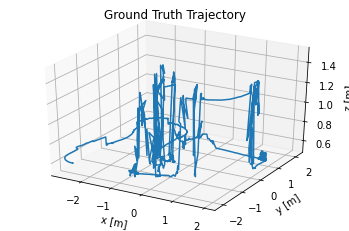

<Figure size 432x288 with 0 Axes>

In [ ]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(pred[:,0], pred[:,1], pred[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth Trajectory')
ax.set_xlim(min(pred[:, 0]), max(pred[:, 0]))
ax.set_ylim(min(pred[:, 1]), max(pred[:, 1]))
ax.set_zlim(min(pred[:, 2]), max(pred[:, 2]))
plt.show()
plt.clf()

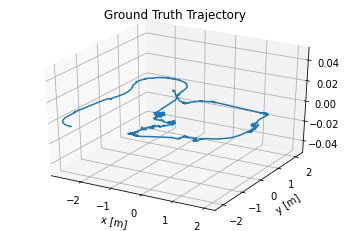

<Figure size 432x288 with 0 Axes>

In [ ]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(pred[:,0], pred[:,1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
# ax.set_zlabel('z [m]')
ax.set_title('Ground Truth Trajectory')
ax.set_xlim(min(pred[:, 0]), max(pred[:, 0]))
ax.set_ylim(min(pred[:, 1]), max(pred[:, 1]))
# ax.set_zlim(min(pred[:, 2]), max(pred[:, 2]))
plt.show()
plt.clf()

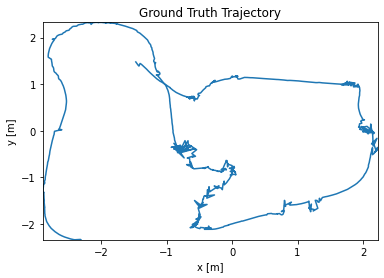

<Figure size 432x288 with 0 Axes>

In [ ]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111)
ax.plot(pred[:,0], pred[:,1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
# ax.set_zlabel('z [m]')
ax.set_title('Ground Truth Trajectory')
ax.set_xlim(min(pred[:, 0]), max(pred[:, 0]))
ax.set_ylim(min(pred[:, 1]), max(pred[:, 1]))
# ax.set_zlim(min(pred[:, 2]), max(pred[:, 2]))
plt.show()
plt.clf()

In [ ]:
gt = np.loadtxt("/content/data/rgbd_dataset_freiburg2_pioneer_slam2/groundtruth.txt")

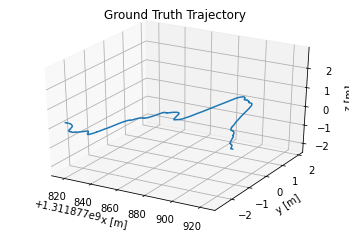

<Figure size 432x288 with 0 Axes>

In [ ]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt[:,0], gt[:,1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth Trajectory')
ax.set_xlim(min(gt[:, 0]), max(gt[:, 0]))
ax.set_ylim(min(gt[:, 1]), max(gt[:, 1]))
ax.set_zlim(min(gt[:, 2]), max(gt[:, 2]))
plt.show()
plt.clf()

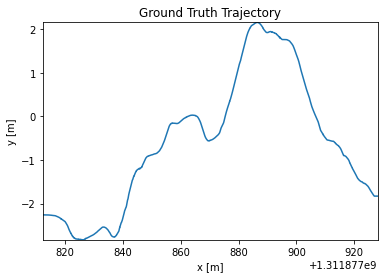

<Figure size 432x288 with 0 Axes>

In [ ]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111)
ax.plot(gt[:,0], gt[:,1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
# ax.set_zlabel('z [m]')
ax.set_title('Ground Truth Trajectory')
ax.set_xlim(min(gt[:, 0]), max(gt[:, 0]))
ax.set_ylim(min(gt[:, 1]), max(gt[:, 1]))
# ax.set_zlim(min(gt[:, 2]), max(gt[:, 2]))
plt.show()
plt.clf()

In [ ]:
max(gt[:, 0]), max(gt[:, 1]), max(gt[:, 2])

(1311877928.0732, 2.1543, 2.9578)

In [ ]:
max(pred[:, 0]), max(pred[:, 1]), max(pred[:, 2])

(-4.3182716, -0.41072416, 5361.066)

#Visulalise

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
lines = np.load("/content/data/all_losses_vptrnn3.npy", allow_pickle=True)

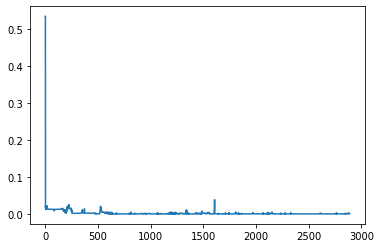

In [ ]:
plt.plot(lines)